In [297]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

## Funções auxiliares

In [292]:
def show_images(*images: np.ndarray, titles: list[str] | None = None, columns: int = 2, scale: int = 5) -> None:
    num_images = len(images)
    
    if titles is None:
        titles = [f'Image {i+1}' for i in range(num_images)]
    
    rows = (num_images + columns - 1) // columns 

    fig, axes = plt.subplots(rows, columns, figsize=(scale * columns, scale * rows))
    axes = np.array(axes).reshape(rows, columns)

    for ax, img, title in zip(axes.flat, images, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)

    # Hide any unused subplots
    for i in range(num_images, rows * columns):
        fig.delaxes(axes.flat[i])

    plt.tight_layout()

def show_image(image: np.ndarray, title: str = None, dpi: int = 100) -> None:
    height, width = image.shape[:2]
    
    figsize = (width / dpi, height / dpi)
    
    plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    plt.title(title if title else "")

    plt.tight_layout()

def get_black_and_white(img: np.ndarray) -> np.ndarray:
    def rgb_to_grayscale(rgb: np.ndarray) -> np.uint8:
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]
    return np.apply_along_axis(rgb_to_grayscale, 2, img)

## Questão 1

Abaixo estão implementadas as funções de:
- Leitura e salvamento de imagens .ppm
- Aplicação do filtro
    - A função `filter_channel` aplica o filtro a apenas um dos canais (r, g ou b), ou seja, um vetor (n, m).

In [160]:
def read_ppm(ppm_path: str) -> np.ndarray:
    """
    Read a PPM file and return its content as a numpy array.
    """
    with open(ppm_path, 'rb') as ppm:
        header = ppm.readline().decode()
        if header.strip() != 'P6':
            raise Exception('Only Raw PPM file supported.')
        
        metadata_count = 0
        metadata = []
        while metadata_count < 2:
            line = ppm.readline().decode()
            if line.startswith('#'):
                continue
            
            metadata.extend([int(v) for v in line.split(' ')])
            metadata_count += 1
            
        width, height, maxval = metadata

        if maxval > 255:
            raise Exception('Only 8-bit images supported.')


        return np.frombuffer(ppm.read(), dtype=np.uint8).reshape((height, width, 3))

def save_ppm(ppm_image: np.ndarray, filename: str, foldername:str='./output') -> None:
    """
    Save a numpy array as a PPM file.
    """
    folder = Path(foldername)
    folder.mkdir(exist_ok=True, parents=True)

    filepath = folder / Path(filename)

    ppm_image = np.clip(ppm_image, 0, 255).astype(np.uint8)

    if len(ppm_image.shape) == 2:
        header = 'P5'
        height, width = ppm_image.shape
    elif len(ppm_image.shape) == 3:
        height, width, _ = ppm_image.shape
        header = 'P6'
    else:
        raise ValueError("Image not supported!")

    maxval = 255

    with open(filepath, 'wb') as ppm:
        ppm.write(f"{header}\n".encode('ascii'))
        ppm.write(f"{width} {height}\n".encode('ascii'))
        ppm.write(f"{maxval}\n".encode('ascii'))
        ppm.write(ppm_image.tobytes())

def filter_channel(img_channel: np.ndarray, kernel_size: int, kernel: np.ndarray) -> np.ndarray:
    output = np.zeros(img_channel.shape, dtype=np.float64)
    kernel = np.flip(kernel, axis=(0,1))
    pad_size = kernel_size // 2

    padded_img = np.pad(img_channel.astype(np.float64), pad_size, mode='constant')
    height, width = padded_img.shape

    for i in range(pad_size, height - pad_size):
        for j in range(pad_size, width - pad_size):
            chunk = padded_img[i - pad_size:i + pad_size + 1, j - pad_size:j + pad_size + 1]
            output[i - pad_size, j - pad_size] = np.sum(chunk * kernel)

    # Normalizar os inputs ao invés de usar np.clip()
    output = (output - np.min(output)) / (np.max(output) - np.min(output)) * 255
    return output.astype(np.uint8)


def apply_filter(img: np.ndarray, kernel_size: int, kernel: np.ndarray) -> np.ndarray:
    filtered_channels = []
    for c in range(3):
        filtered_channels.append(filter_channel(img[:, :, c], kernel_size, kernel))
    
    return np.stack(filtered_channels, axis=-1)


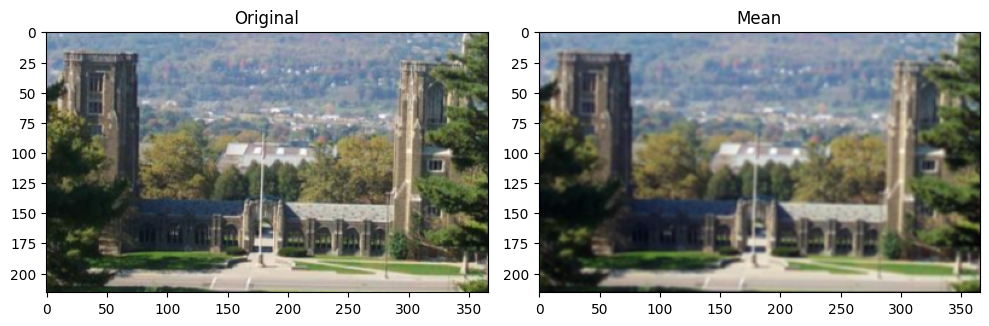

In [142]:
# Aplicando função da questão 1 com filtro média
img_path = '../ppm_images/west_1.ppm'
img = read_ppm(img_path)

n = 3
mean_kernel = 1 / 9 * np.ones((n, n), dtype=np.float64)

filtered = apply_filter(img, n, mean_kernel)
show_images(img, filtered, titles=["Original", "Mean"])
save_ppm(filtered, 'mean.ppm', '../output')

## Questão 2
Como filtro passa-alta, escolhi $I - Gauss$, sendo o kernel do filtro Gaussiano gerado pela função `get_gaussian_kernel` apresentada como resposta em uma [pergunta do stackoverflow](https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy). Optei por buscar uma função, já que o objetivo era gerar uma imagem filtrada para vários valores de $n$ e só havia encontrado kernels para a função gaussiana em tamanho 3x3 e 5x5.

Como é possível ver abaixo, quanto maior é o tamanho do kernel ($n$) maior é o destaque dos detalhes, que são as regiões de alta frequência, ou seja, onde os pixels variam mais de intensidade/cor.

In [143]:
def get_identity_kernel(size: int) -> np.ndarray:
    if size % 2 == 0:
        raise Exception("Kernel must have an odd size.")
    if size <= 1:
        raise Exception("Kernels must have size 3 or greated (and should be odd).")

    identity = np.zeros((size, size), dtype=np.float32)
    identity[size//2, size//2] = 1
    return identity

# Referência: 
# https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy
def get_gaussian_kernel(size=5, sigma=1) -> np.ndarray:
    """
    Creates gaussian kernel with side length `size` and a sigma of `sigma`
    """
    ax = np.linspace(-(size - 1) / 2.0, (size - 1) / 2.0, size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sigma))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

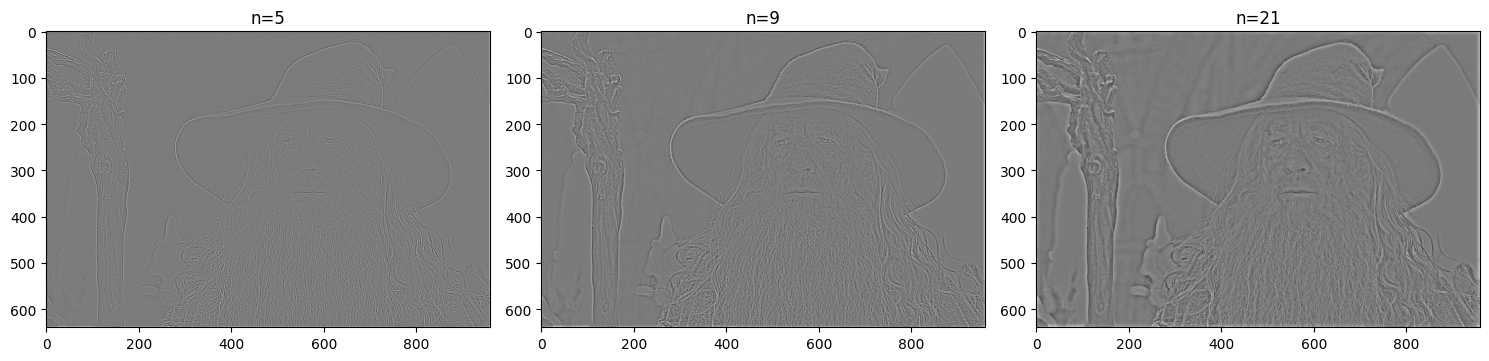

In [144]:
img_path = '../ppm_images/mine/gandalf.ppm'
img = read_ppm(img_path)

images = []
titles = []

for n in [5, 9, 21]:
    identity_kernel = get_identity_kernel(n)
    gauss_kernel = get_gaussian_kernel(n, sigma=5)

    highpass_kernel = identity_kernel - gauss_kernel
    filtered = apply_filter(img, n, highpass_kernel)
    images.append(filtered)
    titles.append(f'n={n}')
    save_ppm(filtered, f'highpass_{n}.ppm', '../output')

show_images(*images, titles=titles, columns=3)

## Questão 3

Um exemplo de filtro que não pode ser aplicado via convolução seria o filtro mediana.

In [145]:
def median_filter_channel(img_channel: np.ndarray, kernel_size: int) -> np.ndarray:
    output = np.zeros(img_channel.shape, dtype=np.float64)
    pad_size = kernel_size // 2
    padded_img = np.pad(img_channel.astype(np.float64), pad_size, mode='constant')
    height, width = padded_img.shape

    for i in range(pad_size, height - pad_size):
        for j in range(pad_size, width - pad_size):
            chunk = padded_img[i - pad_size:i + pad_size + 1, j - pad_size:j + pad_size + 1]
            output[i - pad_size, j - pad_size] = np.median(chunk)

    output = (output - np.min(output)) / (np.max(output) - np.min(output)) * 255
    return np.clip(output, 0, 255).astype(np.uint8)


def apply_median_filter(img: np.ndarray, filter_size: int) -> np.ndarray:
    filtered_channels = []
    for c in range(3):
        filtered_channels.append(median_filter_channel(img[:, :, c], filter_size))
    
    return np.stack(filtered_channels, axis=-1)

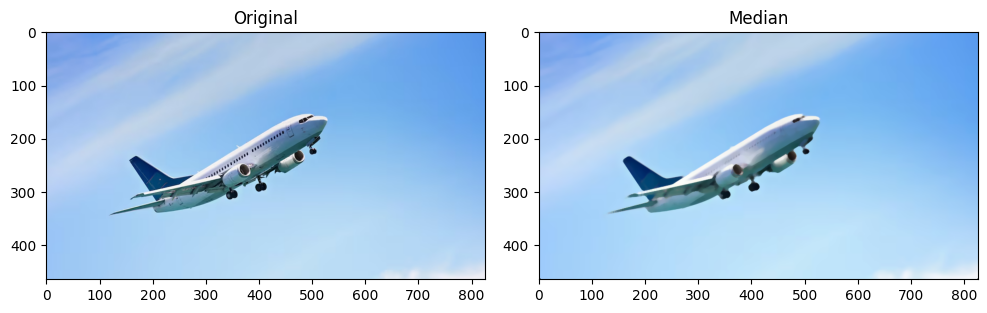

In [146]:
img_path = '../ppm_images/mine/airplane.ppm'
img = read_ppm(img_path)

n = 7
filtered = apply_median_filter(img, n)
show_images(img, filtered, titles=["Original", "Median"])

save_ppm(filtered, 'median.ppm', '../output')

## Questão 4

Abaixo estão as funções utilizadas para obter a derivada de uma imagem usando os filtros de Sobel 3x3 e o para obter o Gradiente da imagem. Apesar de parecidas com as funções anteriores, possuem algumas diferenças, e.g., não é feito o clip dos valores da imagem resultante para que fiquem entre 0 e 255.

In [ ]:
def get_sobel_derivative(img_channel: np.ndarray, kernel_size: int, kernel: np.ndarray) -> np.ndarray:
    output = np.zeros(img_channel.shape)
    kernel = np.flip(kernel, axis=(0,1))
    pad_size = kernel_size // 2

    padded_img = np.pad(img_channel.astype(np.float64), pad_size, mode='constant')
    height, width = padded_img.shape

    for i in range(pad_size, height - pad_size):
        for j in range(pad_size, width - pad_size):
            chunk = padded_img[i - pad_size:i + pad_size + 1, j - pad_size:j + pad_size + 1]
            output[i - pad_size, j - pad_size] = np.sum(chunk * kernel)

    return output

def get_sobel_gradient(img_channel: np.ndarray, kernel_size: int, kernel_x: np.ndarray, kernel_y: np.ndarray) -> np.ndarray:
    output = np.zeros(img_channel.shape)
    kernel_x = np.flip(kernel_x, axis=(0,1))
    kernel_y = np.flip(kernel_y, axis=(0,1))
    pad_size = kernel_size // 2

    padded_img = np.pad(img_channel.astype(np.float64), pad_size, mode='constant')
    height, width = padded_img.shape

    for i in range(pad_size, height - pad_size):
        for j in range(pad_size, width - pad_size):
            chunk = padded_img[i - pad_size:i + pad_size + 1, j - pad_size:j + pad_size + 1]
            gx = np.sum(chunk * kernel_x)
            gy = np.sum(chunk * kernel_y)
            output[i - pad_size, j - pad_size] = np.sqrt(gx**2 + gy**2)

    return output

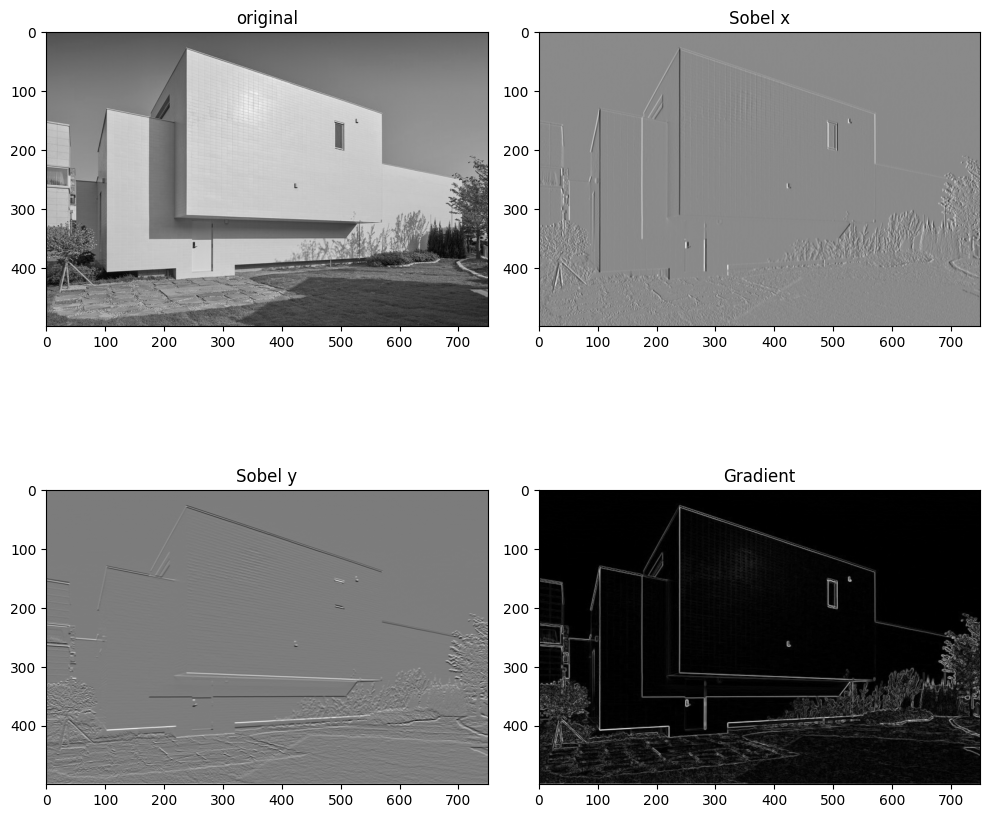

In [147]:
img_path = '../ppm_images/mine/building.ppm'
img = read_ppm(img_path)
bw_img = get_black_and_white(img)

sobel_x_kernel = np.array([[-1, 0, 1], 
                           [-2, 0, 2], 
                           [-1, 0, 1]], dtype=np.float64)
sobel_y_kernel = np.array([[-1, -2, -1], 
                           [ 0,  0,  0], 
                           [ 1,  2,  1]], dtype=np.float64)

sobel_x = get_sobel_derivative(bw_img, 3, sobel_x_kernel)
sobel_y = get_sobel_derivative(bw_img, 3, sobel_y_kernel)
sobel_grad = get_sobel_gradient(bw_img, 3, sobel_x_kernel, sobel_y_kernel)

show_images(bw_img, sobel_x, sobel_y, sobel_grad, titles=["original", "Sobel x", "Sobel y", "Gradient"])

save_ppm(sobel_x, 'sobel_x.ppm', '../output')
save_ppm(sobel_y, 'sobel_y.ppm', '../output')
save_ppm(sobel_grad, 'sobel_gradient.ppm', '../output')

## Questão 5

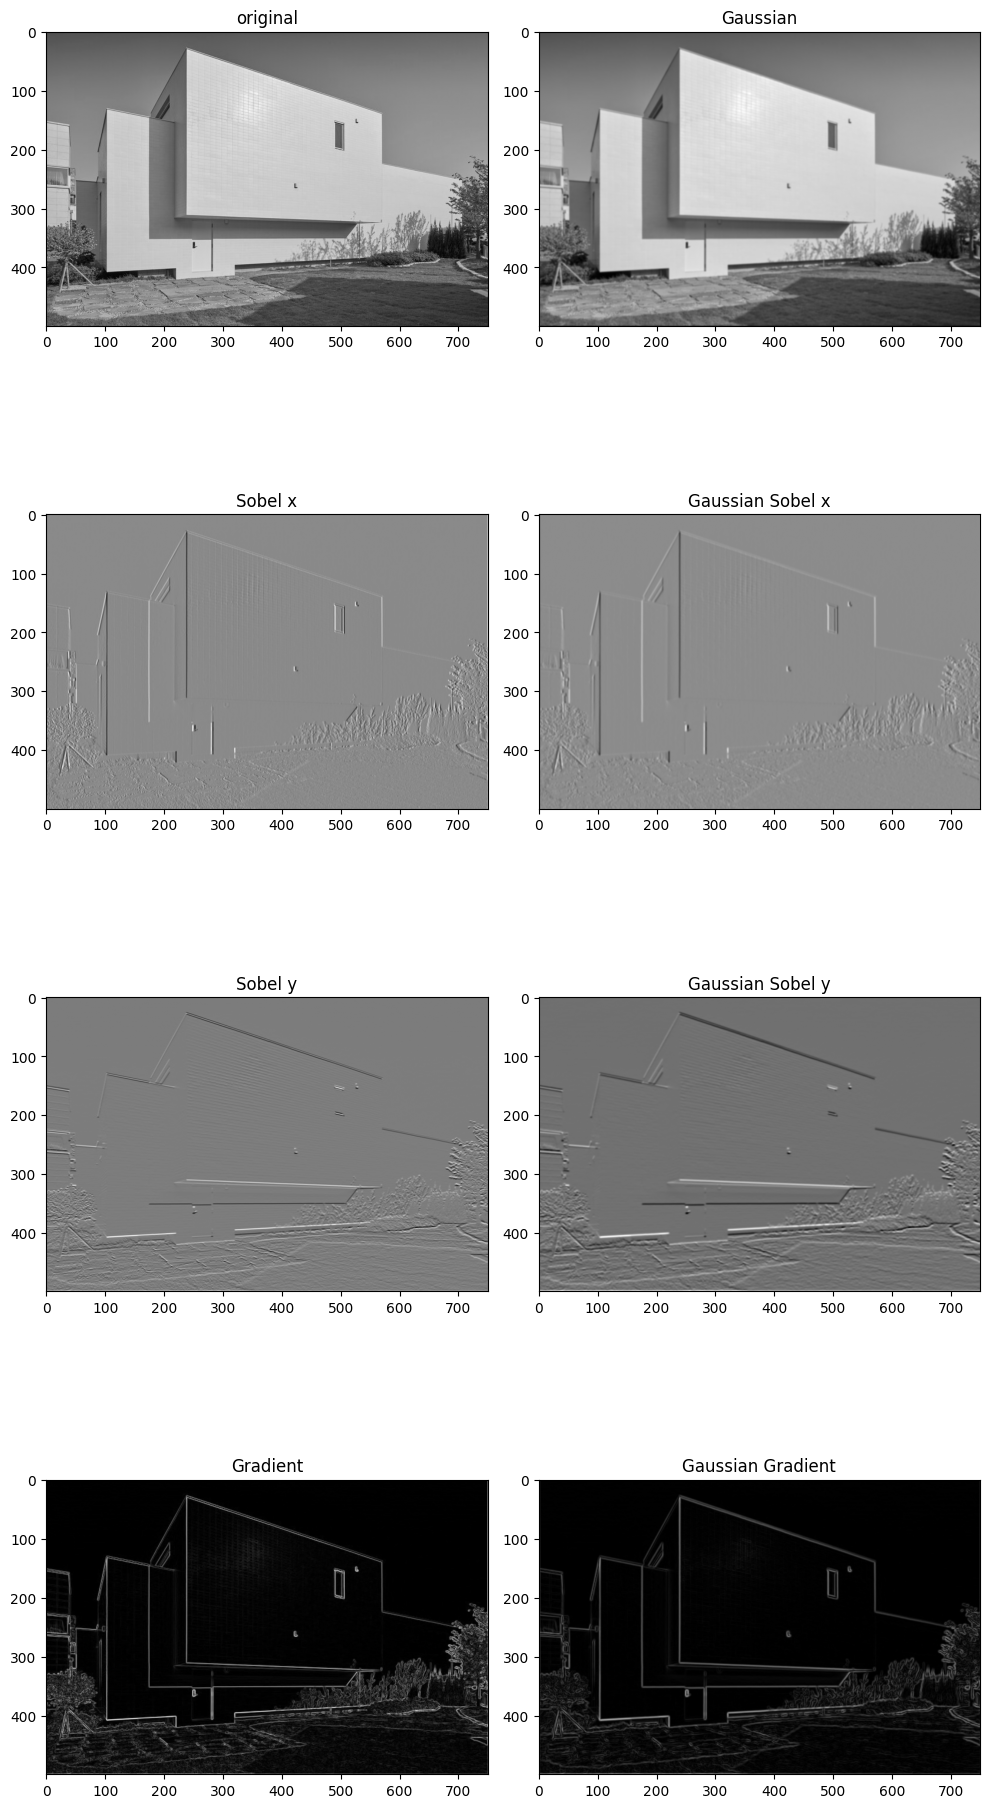

In [ ]:
img_path = '../ppm_images/mine/building.ppm'
img = read_ppm(img_path)

g = np.array([[1, 4, 7, 4, 1],
              [4, 16, 26, 16, 4],
              [7, 26, 41, 26, 7],
              [4, 16, 26, 16, 4],
              [1, 4, 7, 4, 1]], dtype=np.float64) / 273

sobel_x_kernel = np.array([[-1, 0, 1], 
                           [-2, 0, 2], 
                           [-1, 0, 1]], dtype=np.float64)
sobel_y_kernel = np.array([[-1, -2, -1], 
                           [ 0,  0,  0], 
                           [ 1,  2,  1]], dtype=np.float64)

bw_img = get_black_and_white(img)
sobel_x = get_sobel_derivative(bw_img, 3, sobel_x_kernel)
sobel_y = get_sobel_derivative(bw_img, 3, sobel_y_kernel)
sobel_grad = get_sobel_gradient(bw_img, 3, sobel_x_kernel, sobel_y_kernel)

g_bw_image = filter_channel(bw_img, 5, g)
g_sobel_x = get_sobel_derivative(g_bw_image, 3, sobel_x_kernel)
g_sobel_y = get_sobel_derivative(g_bw_image, 3, sobel_y_kernel)
g_sobel_grad = get_sobel_gradient(g_bw_image, 3, sobel_x_kernel, sobel_y_kernel)

g_sobel_grad.shape

images = [
    bw_img, g_bw_image,
    sobel_x, g_sobel_x,
    sobel_y, g_sobel_y,
    sobel_grad, g_sobel_grad
]

titles = [
    "original", "Gaussian",
    "Sobel x", "Gaussian Sobel x",
    "Sobel y",  "Gaussian Sobel y",
    "Gradient", "Gaussian Gradient"
]

show_images(*images, titles=titles)

save_ppm(g_sobel_x, 'gauss_sobel_x.ppm', '../output')
save_ppm(g_sobel_y, 'gauss_sobel_y.ppm', '../output')
save_ppm(g_sobel_grad, 'gauss_sobel_gradient.ppm', '../output')


## Questão 6

In [183]:
img_path = '../ppm_images/mine/flower.ppm'
img = read_ppm(img_path)

# Defaults tirados do exemplo https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html
DEFAULT_T1 = 100
DEFAULT_T2 = 200
DEFAULT_APT = 3

default = cv.Canny(img, DEFAULT_T1, DEFAULT_T2, apertureSize=DEFAULT_APT)

#### Análise de apertureSize

Como é possível ver abaixo, quanto maior é o apertureSize, mais sensível o filtro se torna a arestas. Ou seja, arestas de menor intensidade são identificadas.

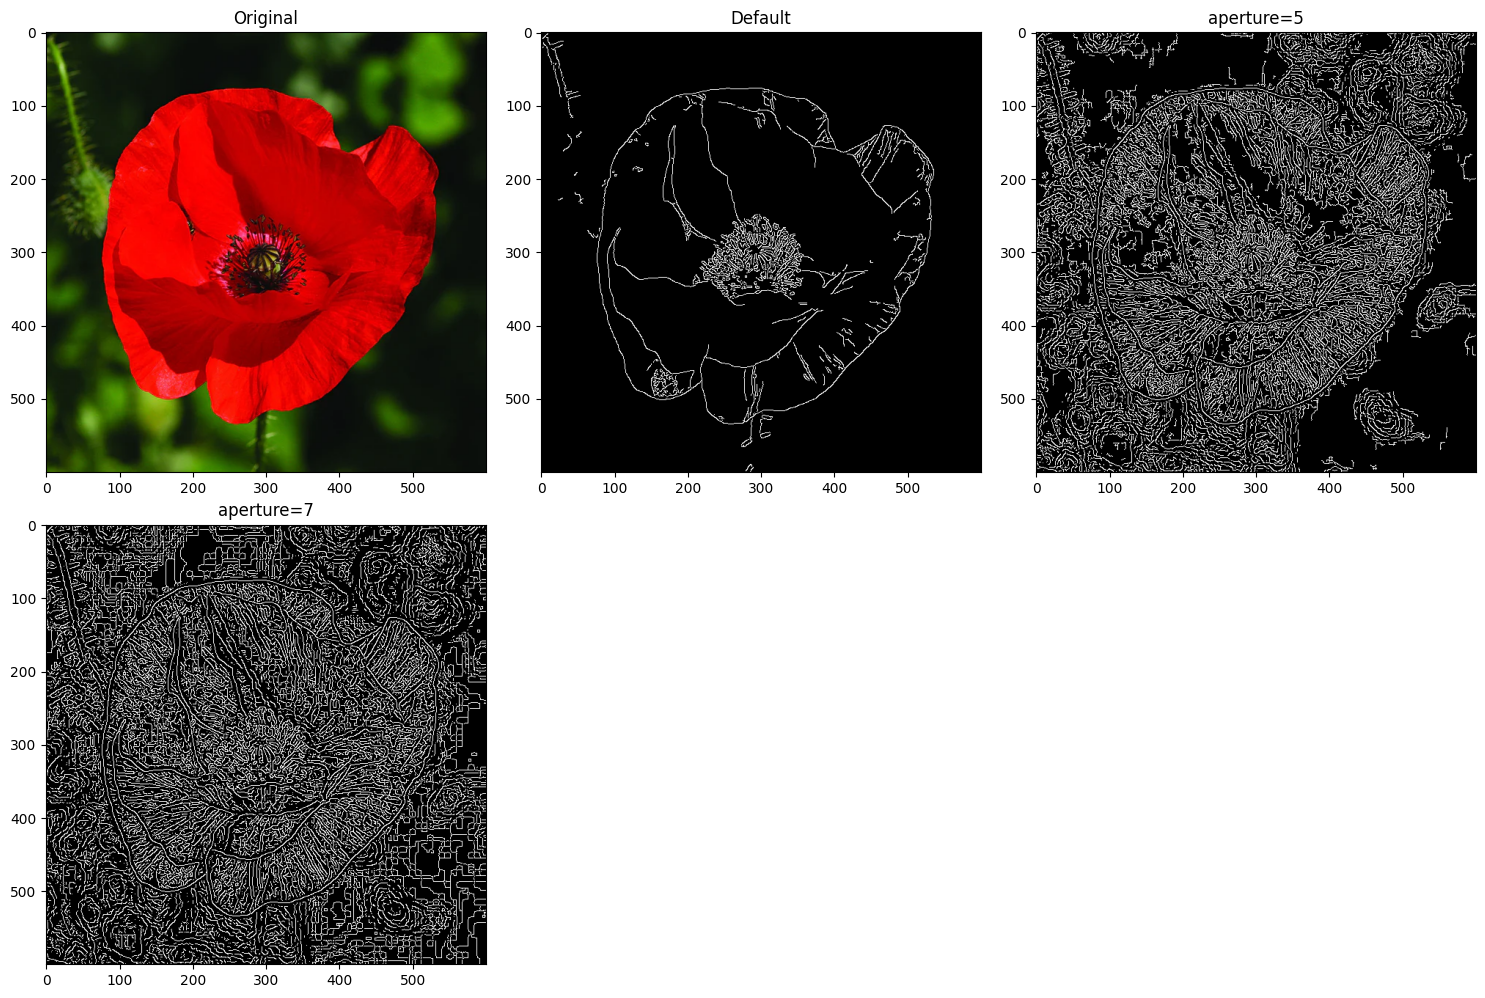

In [184]:
apertures = [5, 7]

aperture_results = []
aperture_titles = []
for aperture in apertures:
    aperture_results.append(cv.Canny(img, DEFAULT_T1, DEFAULT_T2, apertureSize=aperture))
    aperture_titles.append(f"aperture={aperture}")

show_images(img, default, *aperture_results, titles=["Original", "Default", *aperture_titles], columns=3)

#### Análise de thresholds

Threshold 1 (t1) e Threshold 2 (t2) que servem para detectar se uma aresta vai ou não ser destacada. Se o valor da intensidade do gradiente em um ponto for maior que t2, essa aresta com certeza será destacada. Caso o valor da intensidade seja menor que t1, ela com certeza não será mostrada. Valores de intensidade entre os dois thresholds serão escolhidos com base na conectividade. Se uma aresta estão entre t1 e t2, mas está conectada a uma aresta acima de t2, então ela será marcada.

Então, quando aumentamos tanto t1 quanto t2, observamos que a quantidade de arestas destacadas diminui. Entretanto, se aumentarmos de mais, corremos o risco de perder os detalhes relevantes da imagem, como ocorre abaixo.

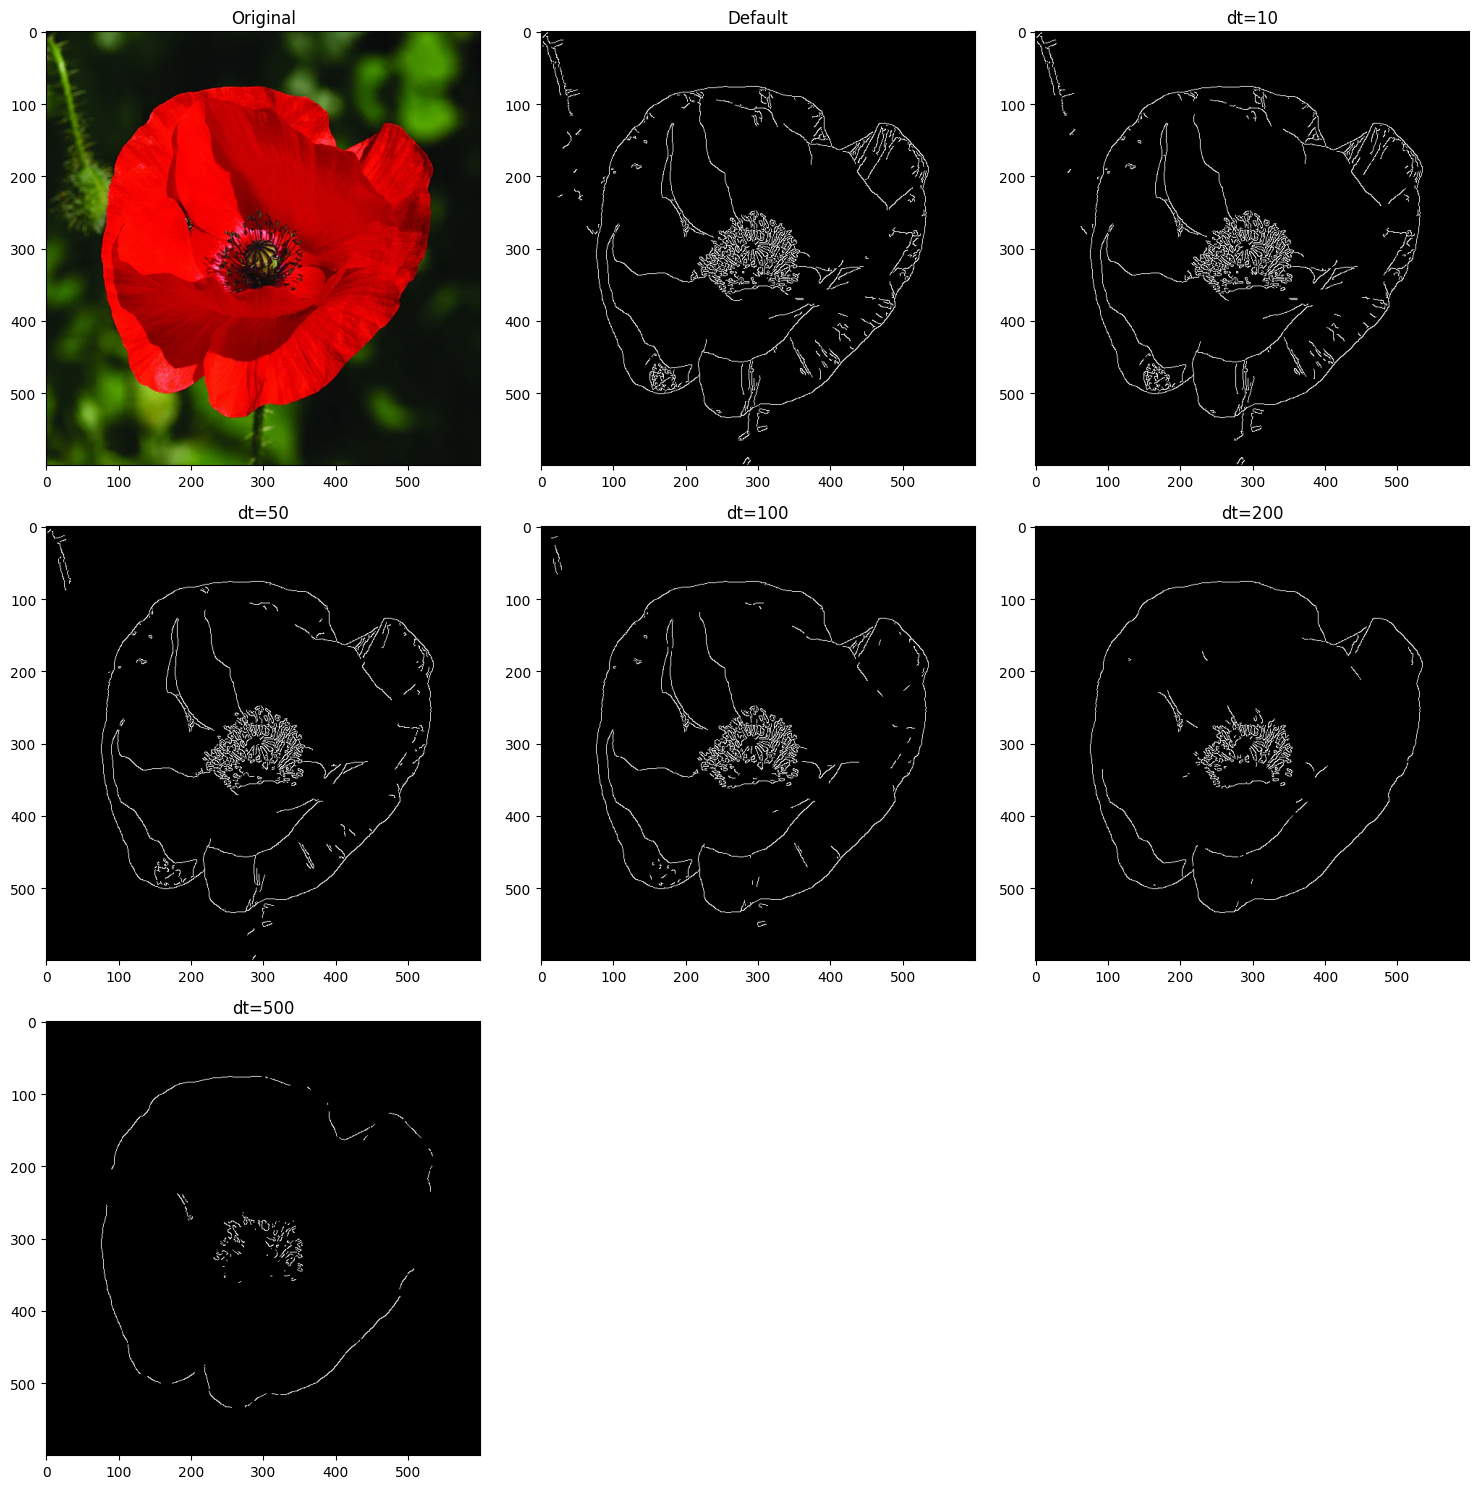

In [193]:
# Deslizando a janela [t1, t2] para cima
dts = [10, 50, 100, 200, 500] 

t1_results = []
t1_titles = []
for dt in dts:
    t1_results.append(cv.Canny(img, DEFAULT_T1 + dt, DEFAULT_T2 + dt, apertureSize=DEFAULT_APT))
    t1_titles.append(f"dt={dt}")

show_images(img, default, *t1_results, titles=["Original", "Default", *t1_titles], columns=3)

Outra forma de analisar seria aumentar o tamanho janela, ao invés de deslizá-la. Nesse caso, aumentamos t2 (o limite máximo), o que impede arestas de baixo valor de intensidade do gradiente. Entretanto, diferente do caso anterior, damos mais chance a arestas que estão conectadas de se manterem. Assim, podemos manter um pouco mais de detalhe.

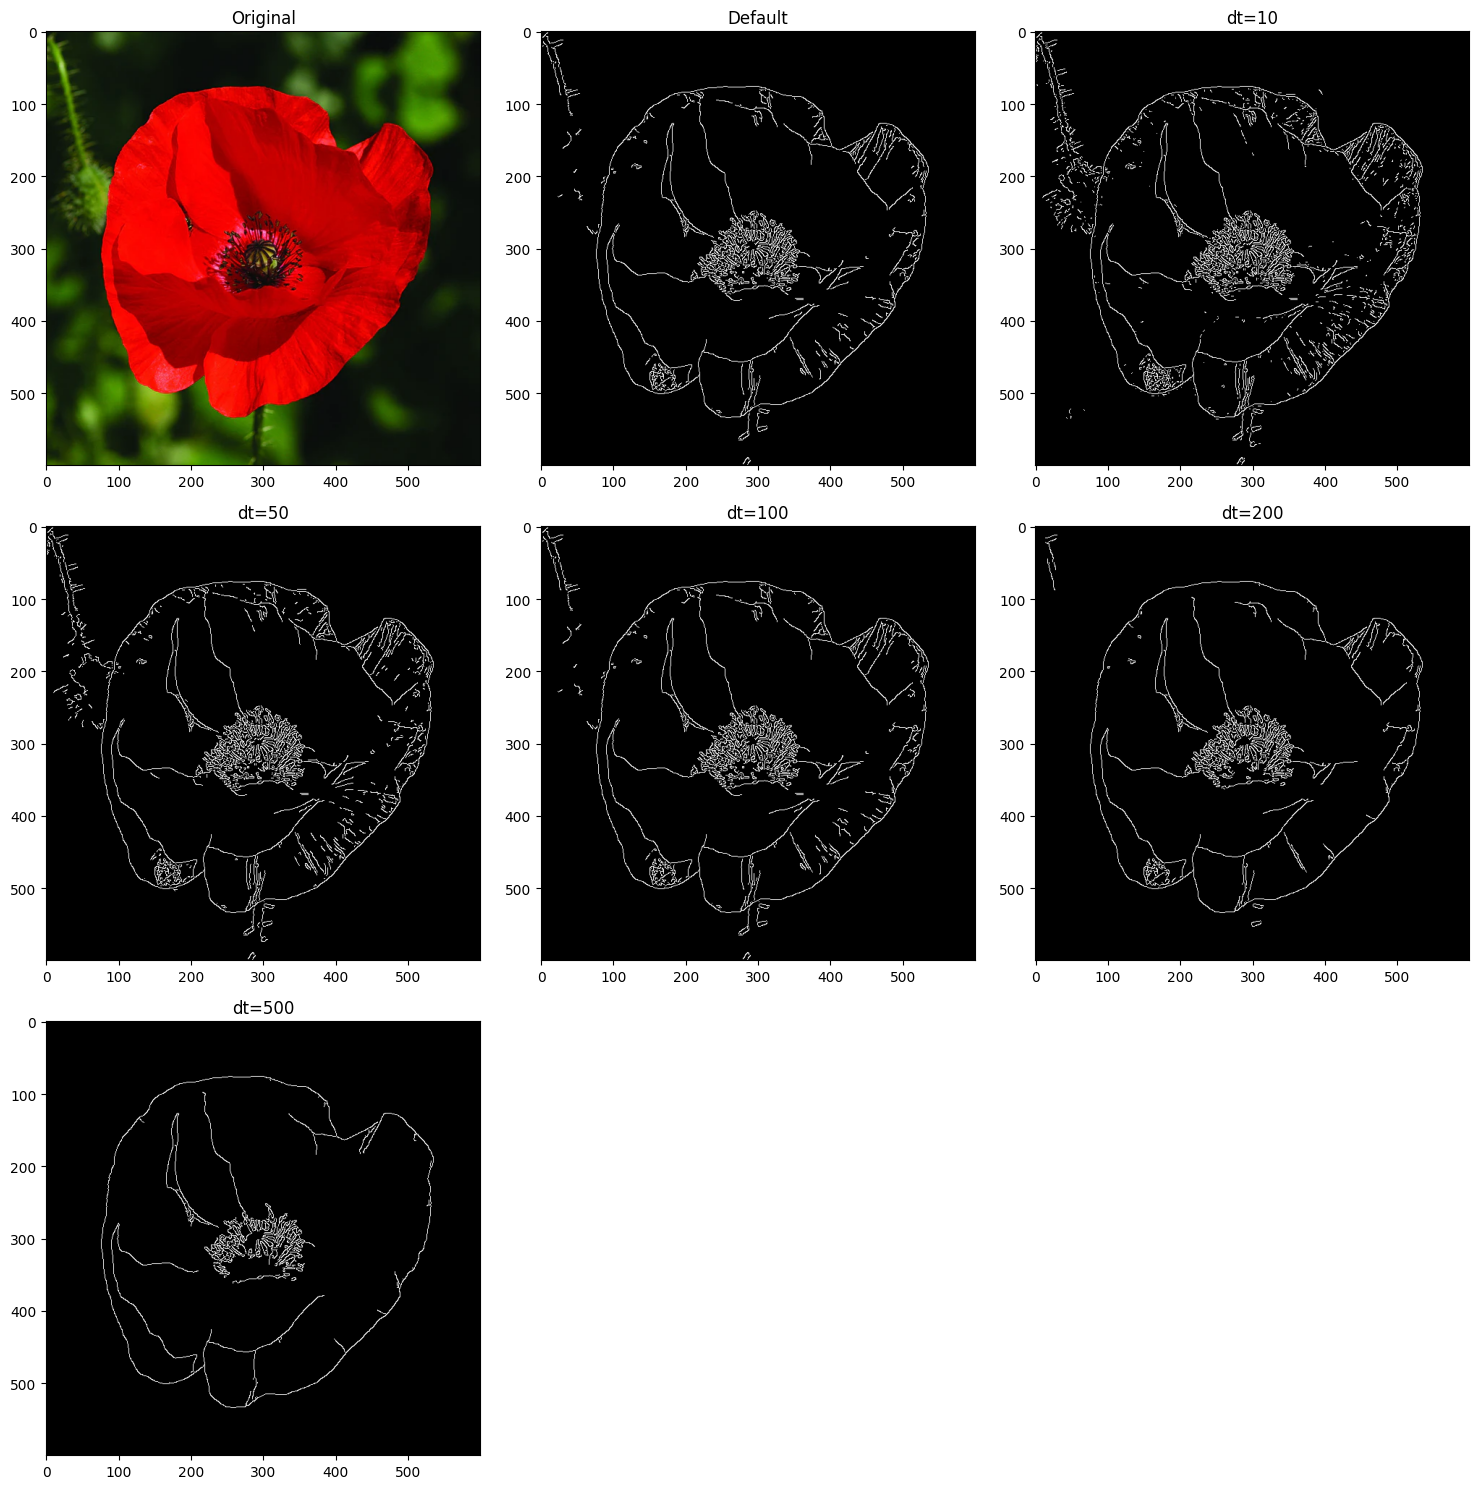

In [ ]:
# Aumentando o tamanho da jenala, ou seja, aumentamos apenas t2
dts = [10, 50, 100, 200, 500] 

t1_results = []
t1_titles = []
for dt in dts:
    t1_results.append(cv.Canny(img, DEFAULT_T1, DEFAULT_T1 + dt, apertureSize=DEFAULT_APT))
    t1_titles.append(f"dt={dt}")

show_images(img, default, *t1_results, titles=["Original", "Default", *t1_titles], columns=3)

## Questão 7

A partir do resultado abaixo, é possível ver que a redução de tamanho sem aplicação de filtro gera anomalias na imagem.

In [293]:
def create_pyramid(images: list[np.ndarray]) -> np.ndarray:
    height, width, _ = images[0].shape
    canvas = np.zeros((height, width + width // 2, 3), dtype=np.uint8)

    canvas[:height, :width] = images[0]

    h_offset = 0
    w_offset = width
    for img in images[1:]:
        h, w, _ = img.shape
        # A operação no array da imagem é necessária, pois as vezes ocorre
        # uma diferença de 1 pixel no tamanho da imagem por conta da diminuição de tamanho
        canvas[h_offset:(h_offset + h), w_offset:(w_offset + w)] = img[:, :canvas.shape[1] - w_offset]
        h_offset += h

    return canvas

def downsize_image_by_2(image: np.ndarray) -> np.ndarray:
    """Downsizes images by a factor of 1/2."""
    new = image[::2, ::2]

    return new

In [294]:
img_path = '../ppm_images/mine/chess.ppm'
img = read_ppm(img_path)

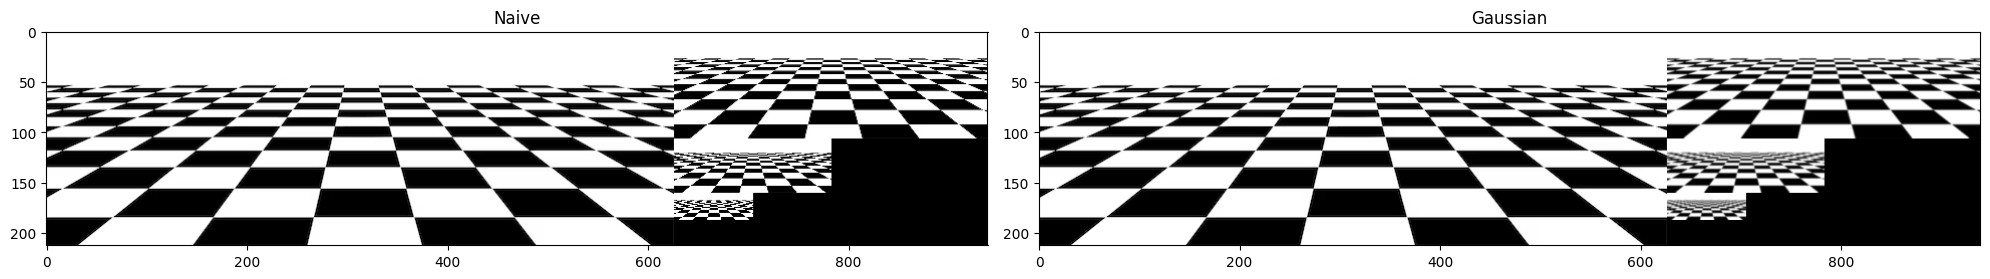

In [295]:
rows, cols, _ = map(int, img.shape)
aux_img = img.copy()
downsize_naive = [aux_img.copy()]
for i in range(3):
    rows = (rows + 1) // 2
    cols = (cols + 1) // 2
    aux_img = downsize_image_by_2(aux_img)
    downsize_naive.append(aux_img.copy())

rows, cols, _ = map(int, img.shape)
aux_img = img.copy()
downsize_gaussian = [aux_img.copy()]
for i in range(3):
    rows = (rows + 1) // 2
    cols = (cols + 1) // 2
    aux_img = cv.pyrDown(aux_img, (cols, rows))
    downsize_gaussian.append(aux_img.copy())

show_images(
    create_pyramid(downsize_naive), 
    create_pyramid(downsize_gaussian), 
    titles=["Naive", "Gaussian"],
    columns=2,
    scale=10
)
